In [59]:
import numpy as np
import scipy
from matplotlib import pyplot

In [200]:
SPATIAL_SAMPLING_RATE = 2200
TIME_SAMPLING_RATE = 48000
FILTER_TAPS = 2000
REFERENCE_ROUGHNESS = 1e-6

In [67]:
def make_noise(filter_taps):
    return np.sqrt(SPATIAL_SAMPLING_RATE / 2) * np.random.normal(size=(filter_taps,))

In [68]:
make_noise(10)

array([-62.13327821,  19.89447856, -50.24573562, -70.63753235,
       -46.40777825,   2.33331901,   4.81041761,  10.99429109,
       -33.25263015,  13.73355933])

In [69]:
def third_octave_band_center(j):
    return 2.0 ** ((j+0.5) / 3.0)
def third_octave_band_width(j):
    return 2.0 ** ((j+1) / 3.0) - 2.0 ** (j / 3.0)

In [70]:
np.sum(third_octave_band_width(np.array([0, 1, 2])))

1.0

In [117]:
Lrtr = np.linspace(10.0, -10.0, 30); Lrtr
# Lrtr = np.array([5.0, 3.0, 2.0, 0.0, 1.0, 0.0, 1.0, -2.0, -3.0, -4.0, -5.0, -6.0, -7.0, -8.0])

array([ 10.        ,   9.31034483,   8.62068966,   7.93103448,
         7.24137931,   6.55172414,   5.86206897,   5.17241379,
         4.48275862,   3.79310345,   3.10344828,   2.4137931 ,
         1.72413793,   1.03448276,   0.34482759,  -0.34482759,
        -1.03448276,  -1.72413793,  -2.4137931 ,  -3.10344828,
        -3.79310345,  -4.48275862,  -5.17241379,  -5.86206897,
        -6.55172414,  -7.24137931,  -7.93103448,  -8.62068966,
        -9.31034483, -10.        ])

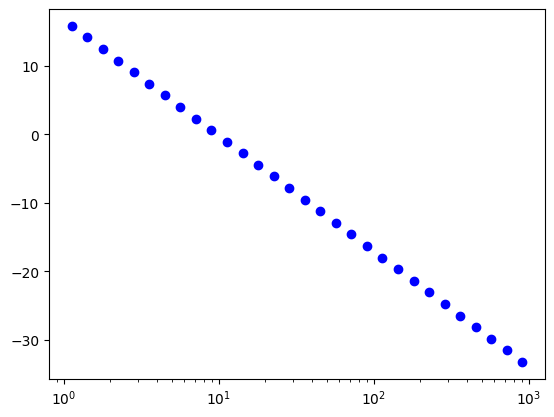

In [118]:
roughness_indices = np.arange(*Lrtr.shape)
roughness_wavenumbers = third_octave_band_center(roughness_indices)
roughness_values = Lrtr - 10 * np.log10(third_octave_band_width(roughness_indices))

pyplot.xscale('log')
pyplot.plot(roughness_wavenumbers, roughness_values, 'bo')

In [119]:
def extrapolate(x_to_find, x, y):
    m, b = np.polyfit(x, y, 1)
    return m * x_to_find + b

In [120]:
roughness_0, roughness_nyquist = extrapolate(np.array((0.0, SPATIAL_SAMPLING_RATE / 2)), roughness_wavenumbers, roughness_values)
roughness_0, roughness_nyquist

(-1.3377966309389817, -56.31840860671854)

These ^ values seem weird but we'll roll with it for now. (I mean, I understand why they're like that, but I'm not sure that this kind of linear extrapolation is quite what is desired.) I'm not sure the _0 value will really matter much anyway, since that will correspond to DC roughness and we end up differentiating.

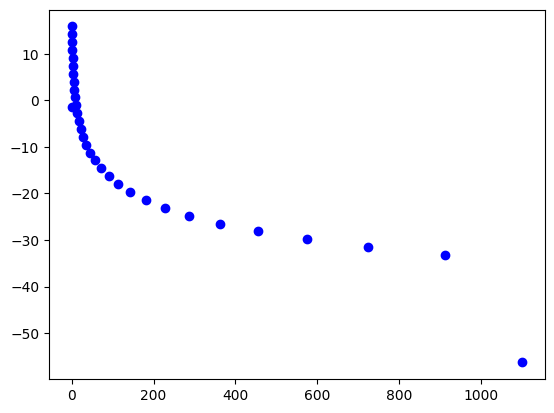

In [121]:
roughness_wavenumbers_full = np.concatenate(([0.0], roughness_wavenumbers, [SPATIAL_SAMPLING_RATE/2]))
roughness_values_full = np.concatenate(([roughness_0], roughness_values, [roughness_nyquist]))
pyplot.plot(roughness_wavenumbers_full, roughness_values_full, 'bo')

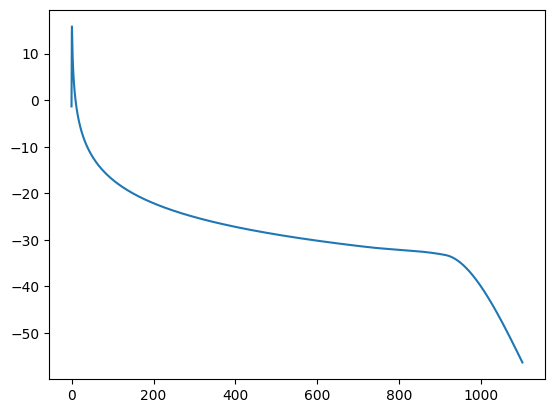

In [132]:
roughness_interpolator = scipy.interpolate.PchipInterpolator(roughness_wavenumbers_full, roughness_values_full)
roughness_fftfreq = scipy.fft.rfftfreq(8192, d=1/SPATIAL_SAMPLING_RATE)
roughness_interpolated = roughness_interpolator(roughness_fftfreq)
pyplot.plot(roughness_fftfreq, roughness_interpolated)

In [133]:
h_basic = scipy.fft.irfft(REFERENCE_ROUGHNESS * 10.0 ** (roughness_interpolated / 20.0))
h_basic

array([8.05862646e-08, 5.58886287e-08, 4.19938025e-08, ...,
       4.05005003e-08, 4.19938025e-08, 5.58886287e-08])

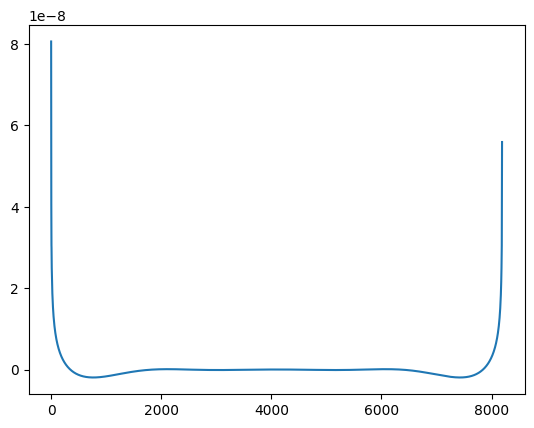

In [134]:
pyplot.plot(h_basic)

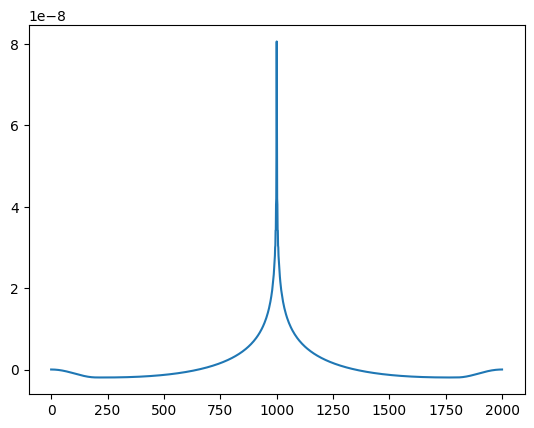

In [140]:
h_track = np.concatenate((h_basic[-FILTER_TAPS//2:], h_basic[:FILTER_TAPS//2])) * scipy.signal.windows.tukey(FILTER_TAPS, alpha=0.2)
pyplot.plot(h_track)

1999.0


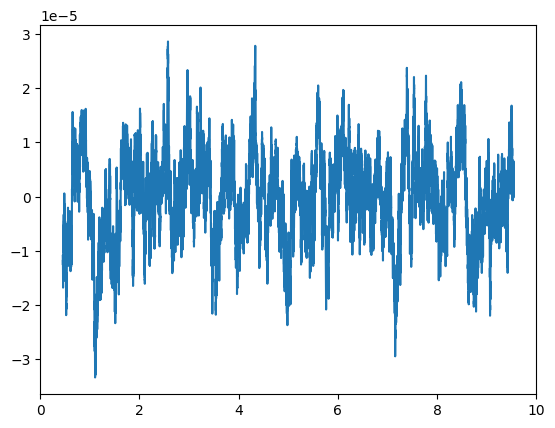

In [180]:
alotta_noise = make_noise(int(SPATIAL_SAMPLING_RATE * 10))
filtered_noise = np.convolve(alotta_noise, h_track, mode='valid')
diff = (alotta_noise.shape[0] - filtered_noise.shape[0]) / (2 * SPATIAL_SAMPLING_RATE)
dist = np.linspace(0 + diff, 10 - diff, filtered_noise.shape[0])
pyplot.plot(np.linspace(0 + diff, 10 - diff, filtered_noise.shape[0]), filtered_noise)

In [280]:
def generate_filter(third_octave_bands, base, attenuate, sample_rate, reference, interpolation_samples, diff, num_taps):
    # filter generation as described in section 3.3.1

    # step 1
    indices = np.arange(*third_octave_bands.shape)
    wavenumbers = base * third_octave_band_center(indices)
    print(wavenumbers)
    values = third_octave_bands - (10 * np.log10(base * third_octave_band_width(indices)) if attenuate else 0)

    # step 2
    value_0, value_nyquist = extrapolate(np.array([0.0, sample_rate/2]), wavenumbers, values)
    wavenumbers_full = np.concatenate(([0.0], wavenumbers, [sample_rate/2]))
    values_full = np.concatenate(([value_0], values, [value_nyquist]))

    # step 3
    interpolator = scipy.interpolate.PchipInterpolator(wavenumbers_full, values_full)
    # TODO: fix this magic number. what should it be? SPATIAL_SAMPLING_RATE?
    freqs = scipy.fft.rfftfreq(interpolation_samples, d=1/SPATIAL_SAMPLING_RATE)
    interpolated = interpolator(freqs)
    # pyplot.plot(interpolated)

    # step 4
    h_basic = scipy.fft.irfft((1j * freqs if diff else 1) * reference * 10.0 ** (interpolated / 20.0))

    # step 5
    h_basic_truncated_shifted = np.concatenate((h_basic[-num_taps//2:], h_basic[:num_taps//2]))
    h_track = h_basic_truncated_shifted * scipy.signal.windows.tukey(num_taps, alpha=0.2)

    return h_track

[  1.12246205   1.41421356   1.78179744   2.2449241    2.82842712
   3.56359487   4.48984819   5.65685425   7.12718975   8.97969639
  11.3137085   14.25437949  17.95939277  22.627417    28.50875898
  35.91878555  45.254834    57.01751796  71.83757109  90.50966799
 114.03503592 143.67514218 181.01933598 228.07007184 287.35028437
 362.03867197 456.14014369 574.70056873 724.07734394 912.28028738]


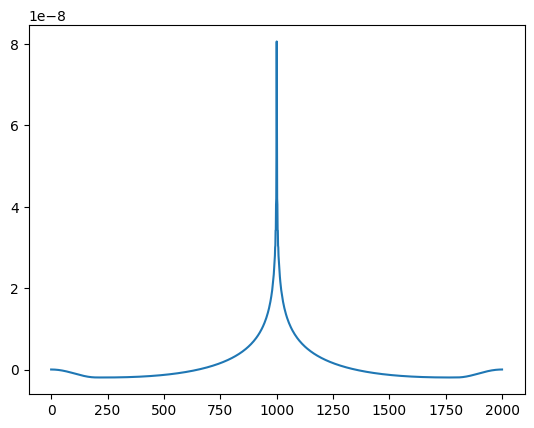

In [281]:
new_h_track = generate_filter(Lrtr, 1, True, SPATIAL_SAMPLING_RATE, REFERENCE_ROUGHNESS, 8192, False, FILTER_TAPS)
pyplot.plot(new_h_track)

[  1.12246205   1.41421356   1.78179744   2.2449241    2.82842712
   3.56359487   4.48984819   5.65685425   7.12718975   8.97969639
  11.3137085   14.25437949  17.95939277  22.627417    28.50875898
  35.91878555  45.254834    57.01751796  71.83757109  90.50966799
 114.03503592 143.67514218 181.01933598 228.07007184 287.35028437
 362.03867197 456.14014369 574.70056873 724.07734394 912.28028738]


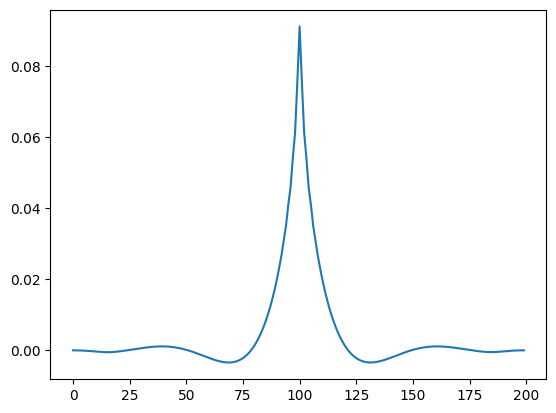

In [282]:
# TODO: is this about right???
# they say the cutoff frequency is about 2.5cm
A_3 = np.concatenate((np.zeros((15,)), np.linspace(0.0, -40.0, 15)))

h_contact = generate_filter(A_3, 1, False, SPATIAL_SAMPLING_RATE, 1.0, 8192, False, 200)
pyplot.plot(h_contact)

In [230]:
def generate_random_roughness(num_samples):
    noise = make_noise(num_samples + h_track.shape[0] + h_contact.shape[0] - 2)
    r_track = np.convolve(noise, h_track, mode='valid')
    return np.convolve(r_track, h_contact, mode='valid')

In [231]:
roughness = generate_random_roughness(48000 * 10)
roughness.shape

(480000,)

In [232]:
import IPython
IPython.display.Audio(roughness, rate=48000)

In [233]:
np.array([4., 3, 2]) * (np.array([1., 2, 3]) > np.array([1.5, 1.5, 1.5]))

array([0., 3., 2.])

In [234]:
def generate_decay(f_u, alpha_u, A_u, tau_u, num_samples):
    t = np.linspace(0.0, num_samples / TIME_SAMPLING_RATE, num_samples).reshape((-1, 1))
    t_off = t - tau_u
    return np.sum(
        A_u * 
        np.e ** (-alpha_u * t_off) *
        np.sin(2 * np.pi * f_u * t_off) *
        (t_off > 0),
        axis=1
    )

generate_decay(np.array([1., 2]), np.array([2., 3]), np.array([3., 4]), np.array([0., 3e-5]), 8)

array([0.        , 0.00044878, 0.0017831 , 0.00342837, 0.00507344,
       0.00671829, 0.00836292, 0.01000734])

In [235]:
def calc_alpha(T_60):
    return 3 * np.log(10.) / T_60

alpha_u = calc_alpha(0.1)

In [236]:
# UGH, i have to get these from the figure (15b)... these are pixel offsets
x_1 = 272
x_2 = 730
peaks = np.array([
    493.,
    793.,
    976.,
    1129.,
    1259.,
])

f_u = 1e3 *  2. ** ((peaks - x_1) / (x_2 - x_1)); f_u

array([1397.19438606, 2200.07786613, 2902.14158285, 3658.31432879,
       4453.75387649])

In [237]:
tau_u = np.random.uniform(high=1/f_u); tau_u

array([2.05876008e-05, 1.94429005e-04, 3.34814687e-04, 1.71490869e-04,
       9.51388079e-05])

In [238]:
# ugh, also from a figure (16)
A_u = 10 * np.log10(np.array([87., 98, 100, 102, 103])); A_u

array([19.39519253, 19.91226076, 20.        , 20.08600172, 20.12837225])

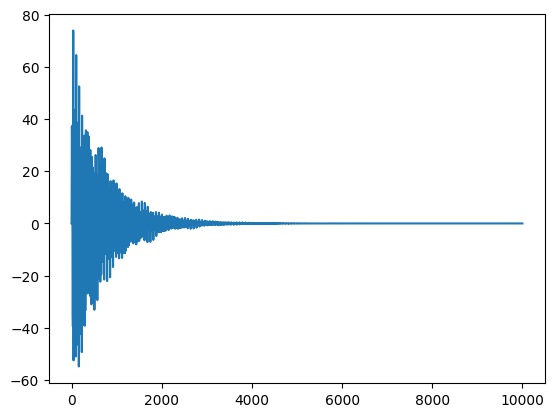

In [239]:
h_decay = generate_decay(f_u, alpha_u, A_u, tau_u, 10000)
pyplot.plot(h_decay)

[   51.63325422    65.05382387    81.96268207   103.26650844
   130.10764774   163.92536414   206.53301689   260.21529548
   327.85072828   413.06603378   520.43059095   655.70145655
   826.13206756  1040.86118191  1311.4029131   1652.26413511
  2081.72236381  2622.80582621  3304.52827022  4163.44472763
  5245.61165241  6609.05654045  8326.88945525 10491.22330482]


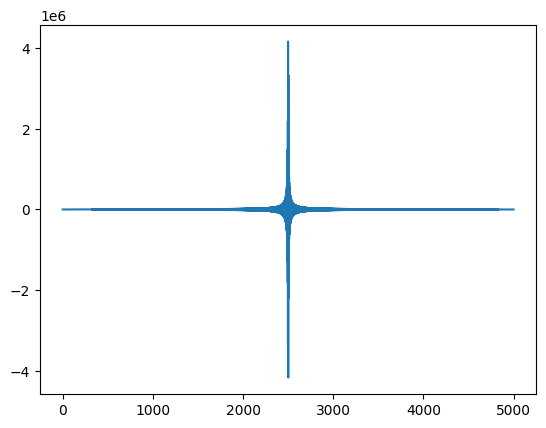

In [283]:
tp_shaping = np.concatenate((
    np.linspace(64.0, 83.0, 13),
    np.array([86.0, 94.0]),
    np.linspace(100.0, 108.0, 9)
))
# pyplot.plot(tp_shaping)
tp_base_freq = 46
h_shape_0 = generate_filter(tp_shaping, tp_base_freq, False, TIME_SAMPLING_RATE, 1.0, TIME_SAMPLING_RATE * 2, True, 5000)
pyplot.plot(h_shape_0)

In [284]:
h_init = np.convolve(h_shape_0, h_decay)

In [285]:
def generate_random_sound(num_samples):
    roughness = generate_random_roughness(num_samples + h_init.shape[0] - 1)
    return np.convolve(roughness, h_init, mode='valid')

In [293]:
s = generate_random_sound(TIME_SAMPLING_RATE * 1)

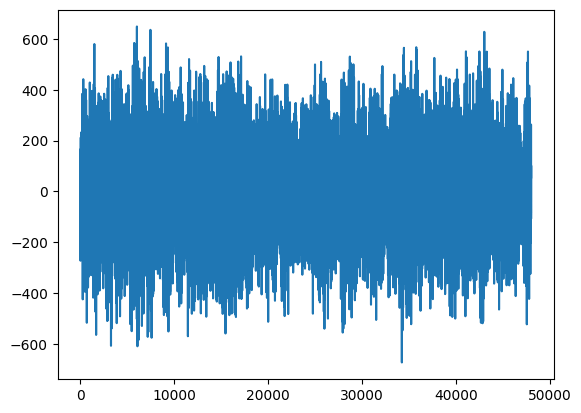

In [294]:
pyplot.plot(s)

In [295]:
IPython.display.Audio(s, rate=48000)

In [292]:
audio_samples = s / np.max(np.abs(s))
scipy.io.wavfile.write("railnoise.wav", TIME_SAMPLING_RATE, audio_samples)